# Import Libraries

In [3]:
# random number generation 
import random 

# numerical and data manipulation libraries
import numpy as np
import pandas as pd

# data visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# path manipulation and file handling
import os
from glob import glob # glob for file pattern matching

# Computer Vision and image processing
import cv2  # OpenCV for image reading, conversion and resizing
from PIL import Image  # Python Imaging Library for alternative image loading

# evaluation metrics and class balancing
from sklearn.utils.class_weight import compute_class_weight # for handling class imbalance
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# deep learning frameworks
import keras
import tensorflow as tf

# model architecture and training utilities (use public API)
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D,Dropout
from keras.callbacks import ReduceLROnPlateau
from keras._tf_keras.keras.preprocessing.image import ImageDataGenerator

import warnings
warnings.filterwarnings('ignore')

# Import Data

In [4]:
# Importing the dataset
train_path = 'D:/UTM/SEM 2/AI/Assignment/Assigment 4/chest_xray/train'
test_path = 'D:/UTM/SEM 2/AI/Assignment/Assigment 4/chest_xray/test'
valid_path = 'D:/UTM/SEM 2/AI/Assignment/Assigment 4/chest_xray/val'

# Get image paths (including different formats,jpeg, jpg and png)
normal_train_paths = glob(os.path.join(train_path, 'NORMAL', '*.jpeg')) + glob(os.path.join(train_path, 'NORMAL', '*.jpg')) 
pneumonia_train_paths = glob(os.path.join(train_path, 'OPACITY', '*.jpeg')) + glob(os.path.join(train_path, 'OPACITY', '*.jpg'))
normal_valid_paths = glob(os.path.join(valid_path, 'NORMAL', '*.jpeg')) + glob(os.path.join(valid_path, 'NORMAL', '*.jpg'))
pneumonia_valid_paths = glob(os.path.join(valid_path, 'OPACITY', '*.jpeg')) + glob(os.path.join(valid_path, 'OPACITY', '*.jpg'))
normal_test_paths = glob(os.path.join(test_path, 'NORMAL', '*.jpeg')) + glob(os.path.join(test_path, 'NORMAL', '*.jpg'))
pneumonia_test_paths = glob(os.path.join(test_path, 'OPACITY', '*.jpeg')) + glob(os.path.join(test_path, 'OPACITY', '*.jpg'))


# Data Exploration

In [5]:
# Function to safely count images in directories (using len to count image)
def images_safe(directory, category):
    return len(glob(os.path.join(directory, category, '*.jpeg'))) + \
            len(glob(os.path.join(directory, category, '*.jpg')))

# Count images in each directory
normal_train_counts = images_safe(train_path, 'NORMAL')
pneumonia_train_counts = images_safe(train_path, 'OPACITY')
normal_test_counts = images_safe(test_path, 'NORMAL')
pneumonia_test_counts= images_safe(test_path, 'OPACITY')
normal_val_counts = images_safe(valid_path, 'NORMAL')
pneumonia_val_counts = images_safe(valid_path, 'OPACITY')

# Print counts
print(f"Training set - Normal: {normal_train_counts}, Pneumonia: {pneumonia_train_counts}")
print(f"Testing set - Normal: {normal_test_counts}, Pneumonia: {pneumonia_test_counts}")
print(f"Validation set - Normal: {normal_val_counts}, Pneumonia: {pneumonia_val_counts}")

# Calculate Total images in each category
total_normal = normal_train_counts + normal_test_counts + normal_val_counts
total_pneumonia = pneumonia_train_counts + pneumonia_test_counts + pneumonia_val_counts
total_images = total_normal + total_pneumonia

print(f"\nTotal images: {total_images}")
print(f"Normal images: {total_normal} ({total_normal/total_images:.2%})")
print(f"Pneumonia images: {total_pneumonia} ({total_pneumonia/total_images:.2%})")

Training set - Normal: 1082, Pneumonia: 3110
Testing set - Normal: 234, Pneumonia: 390
Validation set - Normal: 267, Pneumonia: 773

Total images: 5856
Normal images: 1583 (27.03%)
Pneumonia images: 4273 (72.97%)


There's a significant imbalance between normal and pneumonia images, with pneumonia cases being more prevalent. This imbalance needs to be addressed during model training.

Sample images from training set:


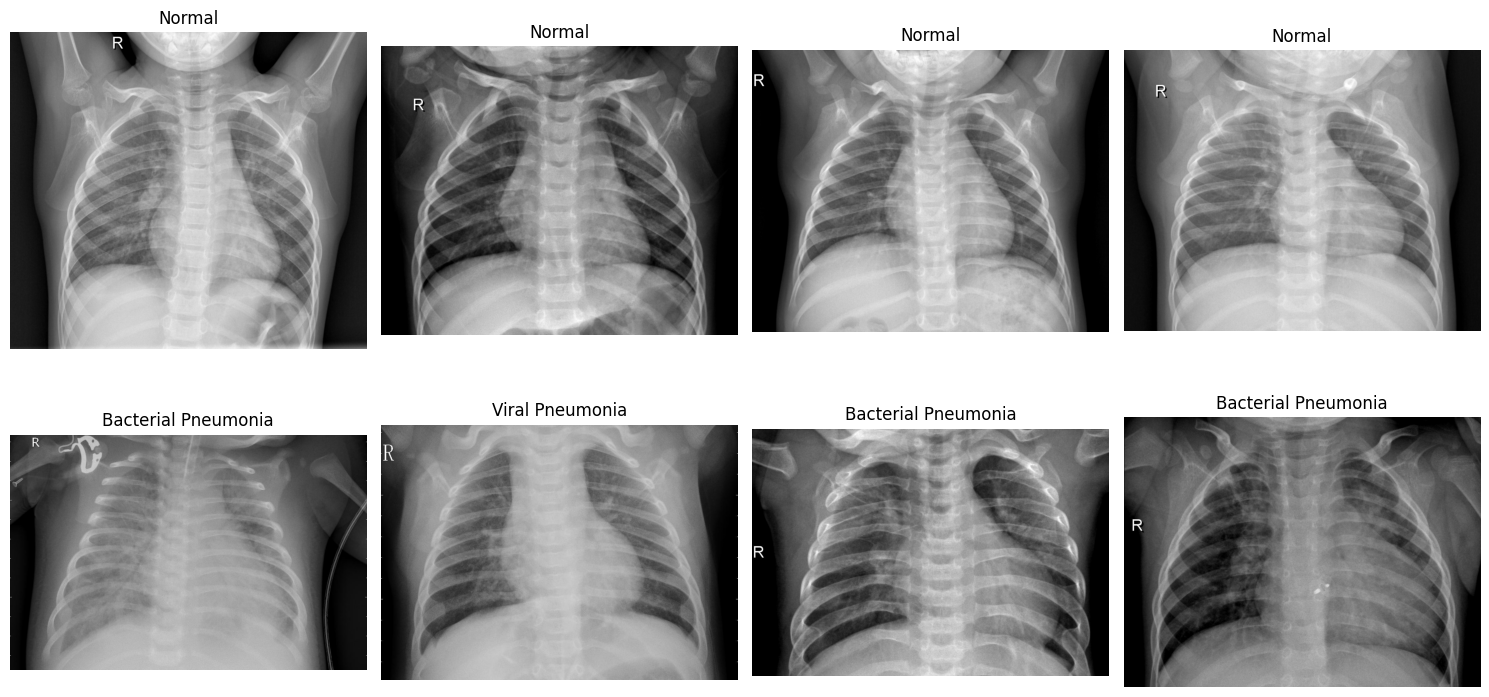

In [6]:
# Display sample images with fixed selection (no randomness)
def display_sample_images(normal_files, pneumonia_files, num_samples=4):
    if not normal_files or not pneumonia_files:
        print("Cannot display samples: missing images")
        return

    num_samples = min(num_samples, len(normal_files), len(pneumonia_files))
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 8))

    for i in range(num_samples):
        # Display normal sample (fixed order)
        img_path = normal_files[i]
        img = cv2.imread(img_path)
        if img is None:
            img = np.zeros((256, 256, 3), dtype=np.uint8)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        axes[0, i].imshow(img)
        axes[0, i].set_title('Normal')
        axes[0, i].axis('off')

        # Display pneumonia sample (fixed order)
        img_path = pneumonia_files[i]
        img = cv2.imread(img_path)
        if img is None:
            img = np.zeros((256, 256, 3), dtype=np.uint8)
        else:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        filename = os.path.basename(img_path).lower()
        if 'bacteria' in filename:
            p_type = 'Bacterial'
        elif 'virus' in filename:
            p_type = 'Viral'
        else:
            p_type = 'Pneumonia'

        axes[1, i].imshow(img)
        axes[1, i].set_title(f'{p_type} Pneumonia')
        axes[1, i].axis('off')

    plt.tight_layout()
    plt.show()


print("Sample images from training set:")
display_sample_images(normal_train_paths, pneumonia_train_paths)

The pneumonia cases include both bacterial and viral pneumonia, which have different visual characteristics in X-rays.

Width - Min: 709, Max: 2498, Mean: 1331.40
Height - Min: 440, Max: 2376, Mean: 996.92


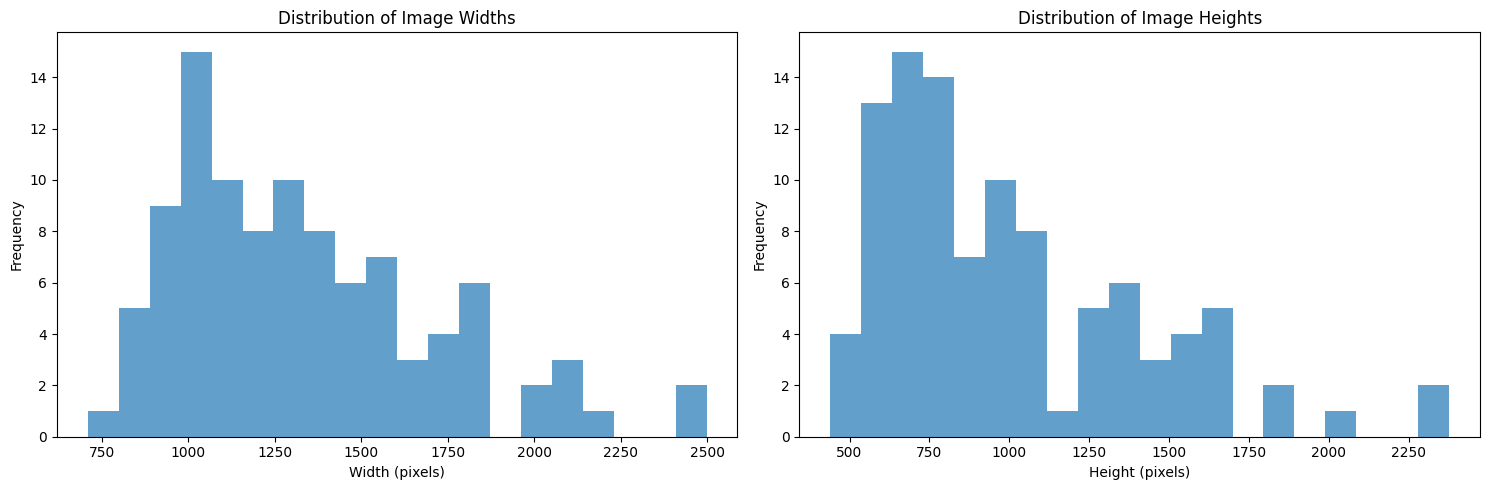

In [7]:
# Combine all available image paths
all_image_paths = normal_train_paths + pneumonia_train_paths + normal_valid_paths + pneumonia_valid_paths + normal_test_paths + pneumonia_test_paths

# Analyze image dimensions
if all_image_paths:
    # Sample random images (up to 100)
    num_samples = min(100, len(all_image_paths))
    sample_paths = random.sample(all_image_paths, num_samples)
    
    widths = []
    heights = []
    
    for img_path in sample_paths:
        try:
            with Image.open(img_path) as img:
                widths.append(img.width)
                heights.append(img.height)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

# Print statistics
print(f"Width - Min: {min(widths)}, Max: {max(widths)}, Mean: {np.mean(widths):.2f}")
print(f"Height - Min: {min(heights)}, Max: {max(heights)}, Mean: {np.mean(heights):.2f}")
        
# Plot dimension distributions
plt.figure(figsize=(15, 5))
        
plt.subplot(1, 2, 1)
plt.hist(widths, bins=20, alpha=0.7)
plt.title('Distribution of Image Widths')
plt.xlabel('Width (pixels)')
plt.ylabel('Frequency')
        
plt.subplot(1, 2, 2)
plt.hist(heights, bins=20, alpha=0.7)
plt.title('Distribution of Image Heights')
plt.xlabel('Height (pixels)')
plt.ylabel('Frequency')
        
plt.tight_layout()
plt.show()

The X-ray images have varying dimensions, which will require resizing to a standard size for our deep learning models.

# Data Preprocessing      
->Resizing images to a standard size       
->Normalizing pixel values      
->Setting up data augmentation to address class imbalance      

In [8]:
# Set image dimensions and batch size
batch_size = 16
img_height = 256
img_width = 256

In [ ]:
# Data augmentation configuration
train_data_augmentation = ImageDataGenerator(
    rescale=1./255, # normalize pixel values to [0, 1]
    shear_range=0.2, # shear transformation
    zoom_range=0.2, # zoom transformation
    horizontal_flip=True 
)

# rescaling for validation and test images (no augmentation)
test_data_augmentation = ImageDataGenerator(rescale=1./255)

In [10]:
# load and preprocess training images with augmentation
train = train_data_augmentation.flow_from_directory(
    train_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
)

# load and preprocess test images (no augmentation, no shuffle)
test = test_data_augmentation.flow_from_directory(
    test_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    shuffle=False,
    class_mode='binary',
    batch_size=batch_size
)

# load and preprocess validation images (no augmentation)
valid = test_data_augmentation.flow_from_directory(
    valid_path,
    target_size=(img_height, img_width),
    color_mode='grayscale',
    class_mode='binary',
    batch_size=batch_size
)

Found 4192 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 1040 images belonging to 2 classes.


# Convolutional Neural Network (CNN)    

In [ ]:
# define a custom Sequential Convolutional Neural Network (CNN)
model_cnn = Sequential()

# first convolutional layer with 32 filters, 3x3 kernel, ReLU activation
model_cnn.add(Conv2D(32, (3, 3), activation="relu", padding='same', input_shape=(img_width, img_height, 1)))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# second convolutional layer with 64 filters
model_cnn.add(Conv2D(64, (3, 3), activation="relu", padding='same'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# third convolutional layer with 64 filters
model_cnn.add(Conv2D(64, (3, 3), activation="relu", padding='same'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# fourth convolutional layer with 128 filters
model_cnn.add(Conv2D(128, (3, 3), activation="relu", padding='same'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# fifth convolutional layer with 256 filters
model_cnn.add(Conv2D(256, (3, 3), activation="relu", padding='same'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# flatten the output before passing to dense layers
model_cnn.add(Flatten())

# fully connected layer with 128 units
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.2))

# fully connected layer with 128 units
model_cnn.add(Dense(128, activation='relu'))
model_cnn.add(Dropout(0.2))

# fully connected layer with 64 units
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dropout(0.1))

# output layer with sigmoid activation for binary classification
model_cnn.add(Dense(1, activation='sigmoid'))

# compile the model using Adam optimizer and binary cross-entropy loss
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# display the model architecture summary
model_cnn.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     2,097,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,546,881 (9.72 MB)

 Trainable params: 2,546,881 (9.72 MB)

 Non-trainable params: 0 (0.00 B)

Tuning the Neural Network (CNN) Model

In [12]:
# reduce learning rate when validation loss plateaus
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_loss',
    patience=2,
    verbose=1,
    factor=0.3,
    min_lr=1e-6
)

# compute class weights to handle imbalanced dataset
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train.classes),
    y=train.classes
)

# convert weights to dictionary format expected by Keras
cw = dict(zip(np.unique(train.classes), weights))

callbacks_list = [learning_rate_reduction]
callbacks = callbacks_list

In [13]:
# train the CNN model based on the training data and validation data
history_cnn = model_cnn.fit(
    train, # training data
    epochs=100,
    validation_data=valid, 
    class_weight=cw,
    callbacks= callbacks_list
)

Epoch 1/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 104s 392ms/step - accuracy: 0.6206 - loss: 0.6403 - val_accuracy: 0.8702 - val_loss: 0.3230 - learning_rate: 0.0010
Epoch 2/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 116s 293ms/step - accuracy: 0.8450 - loss: 0.3255 - val_accuracy: 0.9173 - val_loss: 0.2084 - learning_rate: 0.0010
Epoch 3/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 51s 195ms/step - accuracy: 0.8822 - loss: 0.2769 - val_accuracy: 0.9240 - val_loss: 0.1792 - learning_rate: 0.0010
Epoch 4/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 51s 195ms/step - accuracy: 0.8994 - loss: 0.2274 - val_accuracy: 0.9385 - val_loss: 0.1837 - learning_rate: 0.0010
Epoch 5/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 52s 197ms/step - accuracy: 0.9086 - loss: 0.2270 - val_accuracy: 0.9529 - val_loss: 0.1295 - learning_rate: 0.0010
Epoch 6/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 51s 194ms/step - accuracy: 0.9148 - loss: 0.2112 - val_accuracy: 0.9490 - val_loss: 0.1551 - learning_rate: 0.0010
Epoch 7/100
262/262 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accur

# Neural Network Evaluation

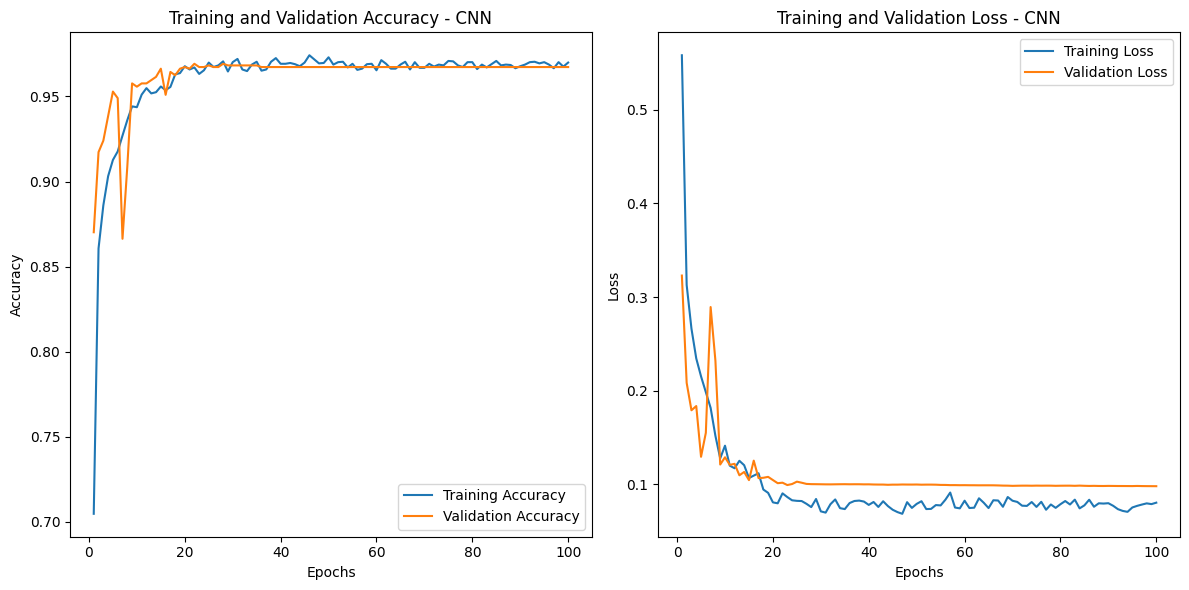

In [14]:
# function to plot training and validation accuracy(loss over epochs)
def plot_training_history(history):
    # extract training and validation metrics from history object
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(12, 6))

    # plot training and validation accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy - CNN')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # plot training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss - CNN')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()
# call the function to display training history plots
plot_training_history(history_cnn)

In [15]:
# Evaluate the model on the test dataset
test_accu = model_cnn.evaluate(test)
print('The accuracy of the model on test dataset is',test_accu[1]*100, '%')

39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 0.8998 - loss: 0.4784
The accuracy of the model on test dataset is 92.30769276618958 %


In [ ]:
# make predictions on the test dataset
preds = model_cnn.predict(test,verbose=1)

# convert predicted probabilities to binary class labels (threshold at 0.5)
predictions = preds.copy()
predictions[predictions <= 0.5] = 0 #value less than or equal to 0.5 is classified as 0 (normal)
predictions[predictions > 0.5] = 1 #value greater than 0.5 is classified as 1 (pneumonia)

# reset the test generator so it starts from the beginning
test.reset()

# concatenate all images and true labels from the test generator
x = np.concatenate([test.__next__()[0] for i in range(len(test))])  # stacked images->all images in the test set
y = np.concatenate([test.__next__()[1] for i in range(len(test))])  # y is truth labels->actual and correct class for each image,\
                                                                    # 0 for normal and 1 for pneumonia

# print shapes for confirmation
print(x.shape)  # shape: (num_samples, height, width, channels)
print(y.shape)  # shape: (num_samples,)

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 62ms/step
(624, 256, 256, 1)
(624,)


20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step


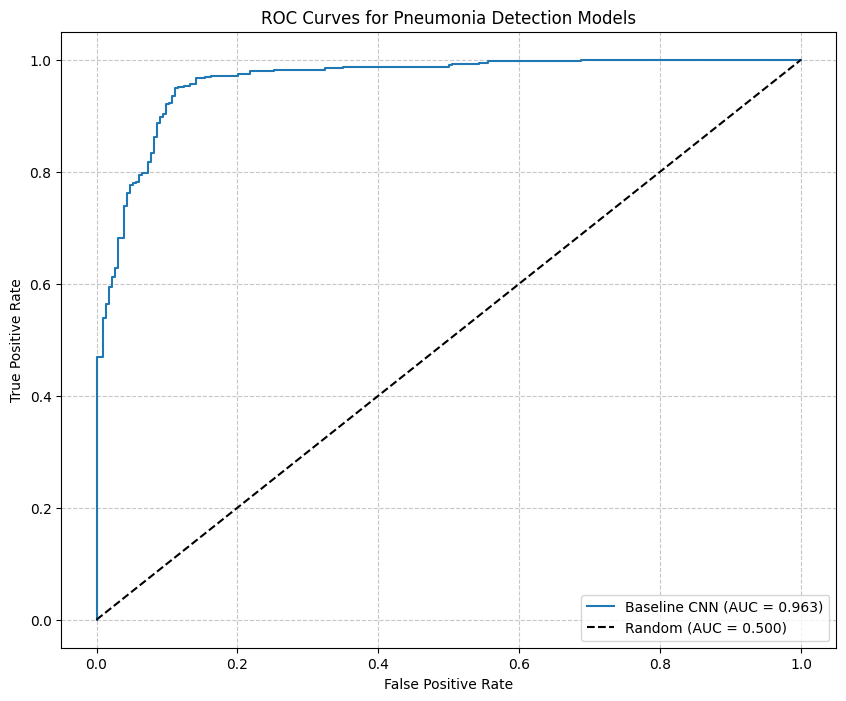

In [28]:
# Plot ROC curves for CNN models
plt.figure(figsize=(10, 8))

# Use your prepared x and y for evaluation
test_preds = model_cnn.predict(x, verbose=1)  # get predictions for the test set
test_probs = test_preds.ravel() # Flatten predictions to 1D array

# Generate ROC curve with true labels y
fpr, tpr, _ = roc_curve(y, test_probs)  # y is the true labels, test_probs are the predicted probabilities
roc_auc = auc(fpr, tpr) 
plt.plot(fpr, tpr, label=f'Baseline CNN (AUC = {roc_auc:.3f})')

# Random classifier
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.500)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Pneumonia Detection Models')
plt.legend(loc='lower right')
plt.grid(linestyle='--', alpha=0.7)
plt.show()

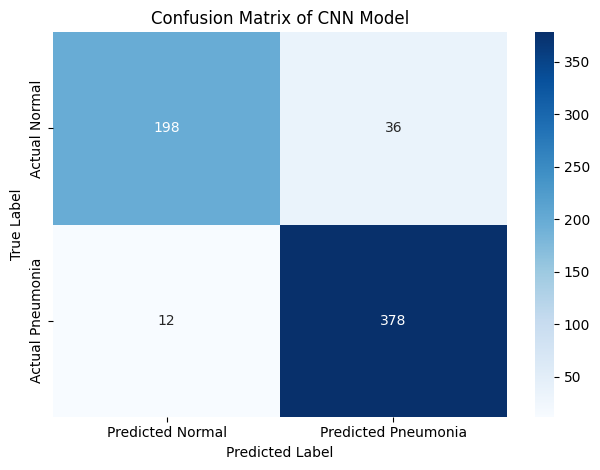

In [32]:
# create a confusion matrix DataFrame
cm = pd.DataFrame(
    data=confusion_matrix(test.classes, predictions, labels=[0, 1]),
    index=["Actual Normal", "Actual Pneumonia"],         # true labels
    columns=["Predicted Normal", "Predicted Pneumonia"]  # predicted labels
)

# plot the confusion matrix using seaborn
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of CNN Model")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [31]:
# generate a classification report including precision, recall, F1-score, and support for each class
print(classification_report(
    y_true=test.classes,          # true labels from the test set
    y_pred=predictions,           # predicted labels from the model
    target_names=['NORMAL', 'PNEUMONIA']  # human-readable class names
))

              precision    recall  f1-score   support

      NORMAL       0.94      0.85      0.89       234
   PNEUMONIA       0.91      0.97      0.94       390

    accuracy                           0.92       624
   macro avg       0.93      0.91      0.92       624
weighted avg       0.92      0.92      0.92       624

